<a href="https://colab.research.google.com/github/mmadduri/BMI_Model/blob/brainAdaptOnly/Winter2020_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Start with this:**

Run the (***simple random search***) iteration

$$ u^+ = u - \frac{\gamma}{N} \sum_{n = 1}^N ( c(u + u_n) - c(u) ) \cdot u_n,\ u_n \sim \mathcal{N}(u,\sigma^2) $$

In our case, the cost function is just the reach error -- calculated by the reach error between the previous lamdba values and the current one. 


Error is defined as reach error: $ error = ||t-y||^2 $ and the perturbation term $ p_{2k+1} $ can be thought of a normal distribution.

$$ \lambda^+ = \lambda - \frac{\nu}{N\delta} \sum_{n = 1}^N ( error(\lambda + \delta p) - error(\lambda) ) \cdot  p, p \sim \mathcal{N}(\lambda,\sigma^2) $$

[[1.25 1.1 ]]
1.3725
2.7725000000000004


<Figure size 432x288 with 0 Axes>

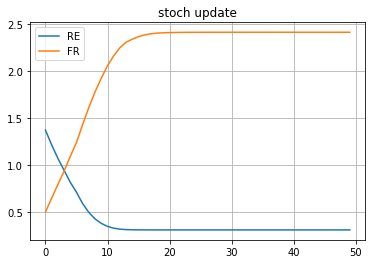

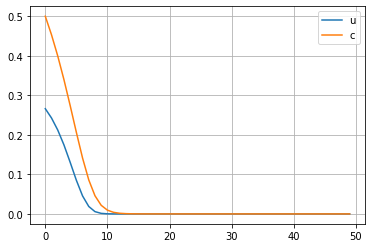

In [0]:
import numpy as np
import matplotlib.pyplot as plt

TARGET_NUM = 2
TARGET_VECTOR = [2, 2]

# Function that generates the adaptation


# ######
# define reach error
# y_x, y_y = matrix of predicted cursor position
# t_x, t_y = matrix of target position
def calcReachError(y_vect, t_vect):
  norm_vect = np.array(y_vect) - np.array(t_vect)
  return (np.linalg.norm(norm_vect, 2)**2)

####################
# Decoder Model 
# K_matx = num neurons x num target 
# K_matx = np.array([[0.5, 0.3, 0.2, 0.1], [0.1, 0.2, 0.3, 0.1]])
K_matx = np.array([[0.5, 0.2]])

# keyword arguments--like a static variable (add states to function)
# make it's optional argument (kwargs)
# might have to make neurons_num global
# firing rate --> a + Kf --> y
def decoder_findY(firing_rate, adaptK):
  global K_matx
  # D(f) = a + Kf = y
  # Start with affine decoder
  a_vect = np.ones(TARGET_NUM)

  if (adaptK == True):
    # Create K_adj matrix 
    K_matx = K_matx

  nextPred_vect = a_vect + np.dot(K_matx, np.squeeze(np.asarray(firing_rate)))
  return (nextPred_vect)

# Note to self: this function is returning a + Kf = y accurately


def reachError_FR(firing_rate):
  y_vect = decoder_findY(firing_rate, False)
  t_vect = TARGET_VECTOR
  return calcReachError(y_vect, t_vect)  

# find next g
# define random search

# this is only 1 iteration of SGD
# takes in a vector lambda 
# start with scalar case
def stochUpdate(input, sigma, delta):
  N_sum = 0
  N_neurons = np.size(input)
  N_samp = 100
  perturb_rand = np.random.normal(0, sigma, N_samp) + input

  for iN in range(N_samp):
    N_sum = N_sum + (reachError_FR(input + delta*perturb_rand[iN]) - reachError_FR(input))*perturb_rand[iN]

  avgUpdate = N_sum/(N_samp*delta)
  # print(avgUpdate)
  return avgUpdate

# param vect = what to update 
def gradDesc(input_init, learn_rate, numIter):
  input_vect = np.array(input_init)
  # param_vect_next = np.array(param_vect)

  err_next = reachError_FR(input_vect[-1])
  err_vect = np.array(err_next)

  delta_vect = np.array(err_next)
  sigma = 1
  delta = 1e-3

  for iT in range(1, numIter, 1):
    # delta_perturb = \Delta_feedback term due to perturbation
    delta_perturb = stochUpdate(input_vect[-1], sigma, delta)
    # lambda+ = lambda - learn_rate*delta_perturb
    # param_vect_next = np.vstack()
    input_vect_next = np.array(input_vect[-1] - learn_rate*delta_perturb)

    err_next = np.array(reachError_FR(input_vect_next))  

    # update vectors 
    input_vect = np.vstack( (input_vect, input_vect_next) )
    err_vect = np.vstack( (err_vect, err_next) )  
    delta_vect = np.vstack( (delta_vect, delta_perturb))

  it_idx = np.linspace(0, numIter, numIter, endpoint=False) 
  plt.figure()
  fig, ax = plt.subplots()

  ax.plot(it_idx, err_vect, label = 'RE')
  ax.plot(it_idx, input_vect, label = 'FR') 
  leg = ax.legend();
  plt.grid()
  plt.title('stoch update')


#### Code

##### TESTING ONLY
# define c, D1_c, D2_c
def cost(u):
  return ((u**6)/6) - (7/5 * u**5) + (17/4 * u**4) - (17/3 * u**3) + (3 * u**2)
def D1_c(u):
  return ((u**5) - (7 * u**4) + (17 * u**3) - (17 * u**2) + (6 * u**1))
def D2_c(u):
  return ((5 * u**4) - (7*4 * u** 3) + (17*3 * u**2) - (17*2 * u) + (6))

#define gradient descent 
def gradDesc_cont(rate, it_num, u_init):
  u_new = [u_init]
  c_new = [cost(u_new[-1])]
  for it in range(1,it_num,1):
    u_new.append(u_new[-1] - rate*D1_c(u_new[-1]))
    c_new.append(cost(u_new[-1]))
  it_idx = np.linspace(0,it_num, it_num, endpoint=False) 
  plt.figure()
  plt.plot(it_idx, c_new)
  plt.plot(it_idx, u_new)

# # Set initial conditions

# #######
# Set initial conditions
learn_rate = 0.1
numIter = 50
fr_init = [0.5]
gradDesc(fr_init, learn_rate, numIter)


rate = 0.1
u_init = 0.5
gradDesc_cont(rate, numIter, u_init)
plt.legend({'c', 'u'})
plt.grid()

e1 = decoder_findY(u_init, False)
print(e1)
print(reachError_FR(u_init))
print(np.linalg.norm(e1, 2)**2)